## Segmenting and Clustering Neighborhoods in Toronto Assignment

#### Question 1 - Website scraping

In [1]:
import pandas as pd

In [2]:
data = pd.read_html("https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M")

In [3]:
print(len(data))

3


In [4]:
#check which series holds the table of postal codes
data[0]

Postal Code           Borough  \
0           M1A      Not assigned   
1           M2A      Not assigned   
2           M3A        North York   
3           M4A        North York   
4           M5A  Downtown Toronto   
..          ...               ...   
175         M5Z      Not assigned   
176         M6Z      Not assigned   
177         M7Z      Not assigned   
178         M8Z         Etobicoke   
179         M9Z      Not assigned   

                                         Neighbourhood  
0                                         Not assigned  
1                                         Not assigned  
2                                            Parkwoods  
3                                     Victoria Village  
4                            Regent Park, Harbourfront  
..                                                 ...  
175                                       Not assigned  
176                                       Not assigned  
177                                       Not assigned  
178  Mimico NW, The Queensway West, South of Bloor,...  
179                                       Not assigned  

[180 rows x 3 columns]

In [5]:
#convert into Pandas dataframe
postal_codes = pd.DataFrame(data[0])

In [6]:
postal_codes.head()

Postal Code           Borough              Neighbourhood
0         M1A      Not assigned               Not assigned
1         M2A      Not assigned               Not assigned
2         M3A        North York                  Parkwoods
3         M4A        North York           Victoria Village
4         M5A  Downtown Toronto  Regent Park, Harbourfront

In [7]:
#Remove an "Not assigned" boroughs
postal_codes = postal_codes.drop(postal_codes[postal_codes["Borough"] == 'Not assigned'].index)

#reset the dataframe index
postal_codes.reset_index(drop=True, inplace=True)
postal_codes.head()

Postal Code           Borough                                Neighbourhood
0         M3A        North York                                    Parkwoods
1         M4A        North York                             Victoria Village
2         M5A  Downtown Toronto                    Regent Park, Harbourfront
3         M6A        North York             Lawrence Manor, Lawrence Heights
4         M7A  Downtown Toronto  Queen's Park, Ontario Provincial Government

In [8]:
postal_codes.shape

(103, 3)

### Question 2

In [9]:
#Install geocoder
#!pip install geocoder

In [10]:
import geocoder # import geocoder
import numpy as np

In [ ]:
"""
# initialize your variable to None
lat_lng_coords = None
Ns=len(postal_codes[["Postal Code"]])
Latitudes = np.zeros(Ns)
Longitudes = np.zeros(Ns)

# loop until you get the coordinates
for postal_code,n in zip(postal_codes["Postal Code"],range(0,Ns):
    print(postal_code)
    while(lat_lng_coords is None):
        g = geocoder.google('{}, Toronto, Ontario'.format(postal_code))
        print(g.latlng)
    Latitudes[n-1]=g.latng[0]
    Longitues[n-1]=g.latlng[1]
"""

During testing, was not able to pull anything but "None" for all postal codes tested. Reverted to using data given in 

In [12]:
import wget

wget.download('http://cocl.us/Geospatial_data', 'long_lat_data_Toronto.csv')


100% [................................................................................] 2891 / 2891

'long_lat_data_Toronto.csv'

In [13]:
long_lats = pd.read_csv('long_lat_data_Toronto.csv')
long_lats.head()

Postal Code   Latitude  Longitude
0         M1B  43.806686 -79.194353
1         M1C  43.784535 -79.160497
2         M1E  43.763573 -79.188711
3         M1G  43.770992 -79.216917
4         M1H  43.773136 -79.239476

In [14]:
long_lats.shape

(103, 3)

In [15]:
postal_codes = postal_codes.join(long_lats.set_index('Postal Code'), on='Postal Code')
postal_codes.head()

Postal Code           Borough                                Neighbourhood  \
0         M3A        North York                                    Parkwoods   
1         M4A        North York                             Victoria Village   
2         M5A  Downtown Toronto                    Regent Park, Harbourfront   
3         M6A        North York             Lawrence Manor, Lawrence Heights   
4         M7A  Downtown Toronto  Queen's Park, Ontario Provincial Government   

    Latitude  Longitude  
0  43.753259 -79.329656  
1  43.725882 -79.315572  
2  43.654260 -79.360636  
3  43.718518 -79.464763  
4  43.662301 -79.389494

### Question 3

In [16]:
import requests
from pandas.io.json import json_normalize
import matplotlib.cm as cm
import matplotlib.colors as colors
from sklearn.cluster import KMeans
import folium

In [17]:
# pulling venue data from Foursquare

In [18]:
CLIENT_ID = 'LKRBWXNWBXJRACJHS4CGS03A4SMSRTFUJRK5KYC2U4151CUW' # your Foursquare ID
CLIENT_SECRET = 'IJXTWYSMLHBBKD1E5NADM2R54COFTFLH3ES2MULIADDTWCNC' # your Foursquare Secret
VERSION = '20180605'
radius=500
LIMIT=100

In [21]:
def getNearbyVenues(pcodes, names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for pcode, name, lat, lng in zip(pcodes, names, latitudes, longitudes):
      
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']

        # return only relevant information for each nearby venue
        venues_list.append([(
            pcode,
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Postal Code',
                  'Borough', 
                  'Postal Code Latitude', 
                  'Postal Code Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [22]:
# run function on all Toronto Boroughs
toronto_venues = getNearbyVenues(pcodes=postal_codes['Postal Code'],
                                   names=postal_codes['Borough'],
                                   latitudes=postal_codes['Latitude'],
                                   longitudes=postal_codes['Longitude']
                                  )
toronto_venues.head()


Postal Code     Borough  Postal Code Latitude  Postal Code Longitude  \
0         M3A  North York             43.753259             -79.329656   
1         M3A  North York             43.753259             -79.329656   
2         M4A  North York             43.725882             -79.315572   
3         M4A  North York             43.725882             -79.315572   
4         M4A  North York             43.725882             -79.315572   

                    Venue  Venue Latitude  Venue Longitude  \
0         Brookbanks Park       43.751976       -79.332140   
1           Variety Store       43.751974       -79.333114   
2  Victoria Village Arena       43.723481       -79.315635   
3               Portugril       43.725819       -79.312785   
4             Tim Hortons       43.725517       -79.313103   

          Venue Category  
0                   Park  
1      Food & Drink Shop  
2           Hockey Arena  
3  Portuguese Restaurant  
4            Coffee Shop

In [23]:
toronto_venues.shape

(2153, 8)

In [24]:
# one hot encoding
toronto_onehot = pd.get_dummies(toronto_venues[['Venue Category']], prefix="", prefix_sep="")

# add postal code column back to dataframe
toronto_onehot['Postal Code'] = toronto_venues['Postal Code'] 

toronto_onehot.head()

Accessories Store  Afghan Restaurant  Airport  Airport Food Court  \
0                  0                  0        0                   0   
1                  0                  0        0                   0   
2                  0                  0        0                   0   
3                  0                  0        0                   0   
4                  0                  0        0                   0   

   Airport Lounge  Airport Service  Airport Terminal  American Restaurant  \
0               0                0                 0                    0   
1               0                0                 0                    0   
2               0                0                 0                    0   
3               0                0                 0                    0   
4               0                0                 0                    0   

   Antique Shop  Aquarium  ...  Video Game Store  Video Store  \
0             0         0  ...                 0            0   
1             0         0  ...                 0            0   
2             0         0  ...                 0            0   
3             0         0  ...                 0            0   
4             0         0  ...                 0            0   

   Vietnamese Restaurant  Warehouse Store  Wine Bar  Wine Shop  Wings Joint  \
0                      0                0         0          0            0   
1                      0                0         0          0            0   
2                      0                0         0          0            0   
3                      0                0         0          0            0   
4                      0                0         0          0            0   

   Women's Store  Yoga Studio  Postal Code  
0              0            0          M3A  
1              0            0          M3A  
2              0            0          M4A  
3              0            0          M4A  
4              0            0          M4A  

[5 rows x 270 columns]

In [25]:
# move postal code column to the first column
fixed_columns = [toronto_onehot.columns[-1]] + list(toronto_onehot.columns[:-1])
toronto_onehot = toronto_onehot[fixed_columns]

In [26]:
toronto_onehot.head()

Postal Code  Accessories Store  Afghan Restaurant  Airport  \
0         M3A                  0                  0        0   
1         M3A                  0                  0        0   
2         M4A                  0                  0        0   
3         M4A                  0                  0        0   
4         M4A                  0                  0        0   

   Airport Food Court  Airport Lounge  Airport Service  Airport Terminal  \
0                   0               0                0                 0   
1                   0               0                0                 0   
2                   0               0                0                 0   
3                   0               0                0                 0   
4                   0               0                0                 0   

   American Restaurant  Antique Shop  ...  Vegetarian / Vegan Restaurant  \
0                    0             0  ...                              0   
1                    0             0  ...                              0   
2                    0             0  ...                              0   
3                    0             0  ...                              0   
4                    0             0  ...                              0   

   Video Game Store  Video Store  Vietnamese Restaurant  Warehouse Store  \
0                 0            0                      0                0   
1                 0            0                      0                0   
2                 0            0                      0                0   
3                 0            0                      0                0   
4                 0            0                      0                0   

   Wine Bar  Wine Shop  Wings Joint  Women's Store  Yoga Studio  
0         0          0            0              0            0  
1         0          0            0              0            0  
2         0          0            0              0            0  
3         0          0            0              0            0  
4         0          0            0              0            0  

[5 rows x 270 columns]

In [27]:
len(toronto_onehot['Postal Code'].unique())

100

In [28]:
#group by postal code and average values
toronto_grouped = toronto_onehot.groupby('Postal Code').mean().reset_index()
toronto_grouped.head()

Postal Code  Accessories Store  Afghan Restaurant  Airport  \
0         M1B                0.0                0.0      0.0   
1         M1C                0.0                0.0      0.0   
2         M1E                0.0                0.0      0.0   
3         M1G                0.0                0.0      0.0   
4         M1H                0.0                0.0      0.0   

   Airport Food Court  Airport Lounge  Airport Service  Airport Terminal  \
0                 0.0             0.0              0.0               0.0   
1                 0.0             0.0              0.0               0.0   
2                 0.0             0.0              0.0               0.0   
3                 0.0             0.0              0.0               0.0   
4                 0.0             0.0              0.0               0.0   

   American Restaurant  Antique Shop  ...  Vegetarian / Vegan Restaurant  \
0                  0.0           0.0  ...                            0.0   
1                  0.0           0.0  ...                            0.0   
2                  0.0           0.0  ...                            0.0   
3                  0.0           0.0  ...                            0.0   
4                  0.0           0.0  ...                            0.0   

   Video Game Store  Video Store  Vietnamese Restaurant  Warehouse Store  \
0               0.0          0.0                    0.0              0.0   
1               0.0          0.0                    0.0              0.0   
2               0.0          0.0                    0.0              0.0   
3               0.0          0.0                    0.0              0.0   
4               0.0          0.0                    0.0              0.0   

   Wine Bar  Wine Shop  Wings Joint  Women's Store  Yoga Studio  
0       0.0        0.0          0.0            0.0          0.0  
1       0.0        0.0          0.0            0.0          0.0  
2       0.0        0.0          0.0            0.0          0.0  
3       0.0        0.0          0.0            0.0          0.0  
4       0.0        0.0          0.0            0.0          0.0  

[5 rows x 270 columns]

In [29]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [38]:
#sort dataframe to get top 5 venue categories per postal code
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Postal Code']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
pcode_venues_sorted = pd.DataFrame(columns=columns)
pcode_venues_sorted['Postal Code'] = toronto_grouped['Postal Code']
toronto_grouped.shape

(100, 270)

In [39]:
for ind in np.arange(toronto_grouped.shape[0]):
    pcode_venues_sorted.iloc[ind, 1:] = return_most_common_venues(toronto_grouped.iloc[ind, :], num_top_venues)

pcode_venues_sorted.head()

Postal Code 1st Most Common Venue 2nd Most Common Venue  \
0         M1B            Print Shop  Fast Food Restaurant   
1         M1C                   Bar           Yoga Studio   
2         M1E    Mexican Restaurant     Electronics Store   
3         M1G           Coffee Shop          Soccer Field   
4         M1H                  Bank      Hakka Restaurant   

  3rd Most Common Venue 4th Most Common Venue 5th Most Common Venue  \
0           Yoga Studio    Dim Sum Restaurant                 Diner   
1            Donut Shop                 Diner        Discount Store   
2            Restaurant        Breakfast Spot   Rental Car Location   
3     Korean Restaurant            Donut Shop    Dim Sum Restaurant   
4   Fried Chicken Joint  Caribbean Restaurant    Athletics & Sports   

  6th Most Common Venue 7th Most Common Venue 8th Most Common Venue  \
0        Discount Store   Distribution Center               Dog Run   
1   Distribution Center               Dog Run      Doner Restaurant   
2        Medical Center                  Bank          Intersection   
3                 Diner        Discount Store   Distribution Center   
4       Thai Restaurant           Gas Station                Bakery   

  9th Most Common Venue 10th Most Common Venue  
0      Doner Restaurant             Donut Shop  
1             Drugstore         Farmers Market  
2           Yoga Studio         Discount Store  
3               Dog Run       Doner Restaurant  
4        Discount Store     Dim Sum Restaurant

#### K clustering

In [40]:
# set number of clusters
kclusters = 10

toronto_grouped_clustering = toronto_grouped.drop('Postal Code', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(toronto_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([1, 0, 1, 9, 1, 4, 9, 1, 1, 1])

In [41]:
# add clustering labels
pcode_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

pcode_venues_sorted['Cluster Labels'] = pcode_venues_sorted['Cluster Labels'].astype(int)
pcode_venues_sorted.head()

Cluster Labels Postal Code 1st Most Common Venue 2nd Most Common Venue  \
0               1         M1B            Print Shop  Fast Food Restaurant   
1               0         M1C                   Bar           Yoga Studio   
2               1         M1E    Mexican Restaurant     Electronics Store   
3               9         M1G           Coffee Shop          Soccer Field   
4               1         M1H                  Bank      Hakka Restaurant   

  3rd Most Common Venue 4th Most Common Venue 5th Most Common Venue  \
0           Yoga Studio    Dim Sum Restaurant                 Diner   
1            Donut Shop                 Diner        Discount Store   
2            Restaurant        Breakfast Spot   Rental Car Location   
3     Korean Restaurant            Donut Shop    Dim Sum Restaurant   
4   Fried Chicken Joint  Caribbean Restaurant    Athletics & Sports   

  6th Most Common Venue 7th Most Common Venue 8th Most Common Venue  \
0        Discount Store   Distribution Center               Dog Run   
1   Distribution Center               Dog Run      Doner Restaurant   
2        Medical Center                  Bank          Intersection   
3                 Diner        Discount Store   Distribution Center   
4       Thai Restaurant           Gas Station                Bakery   

  9th Most Common Venue 10th Most Common Venue  
0      Doner Restaurant             Donut Shop  
1             Drugstore         Farmers Market  
2           Yoga Studio         Discount Store  
3               Dog Run       Doner Restaurant  
4        Discount Store     Dim Sum Restaurant

In [42]:
toronto_merged = postal_codes

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
toronto_merged = toronto_merged.join(pcode_venues_sorted.set_index('Postal Code'), on='Postal Code')


In [43]:
toronto_merged = toronto_merged[toronto_merged['Cluster Labels'].notna()]
toronto_merged['Cluster Labels'] = toronto_merged['Cluster Labels'].astype(int)
#
toronto_merged# check the last columns!

Postal Code           Borough  \
0           M3A        North York   
1           M4A        North York   
2           M5A  Downtown Toronto   
3           M6A        North York   
4           M7A  Downtown Toronto   
..          ...               ...   
98          M8X         Etobicoke   
99          M4Y  Downtown Toronto   
100         M7Y      East Toronto   
101         M8Y         Etobicoke   
102         M8Z         Etobicoke   

                                         Neighbourhood   Latitude  Longitude  \
0                                            Parkwoods  43.753259 -79.329656   
1                                     Victoria Village  43.725882 -79.315572   
2                            Regent Park, Harbourfront  43.654260 -79.360636   
3                     Lawrence Manor, Lawrence Heights  43.718518 -79.464763   
4          Queen's Park, Ontario Provincial Government  43.662301 -79.389494   
..                                                 ...        ...        ...   
98       The Kingsway, Montgomery Road, Old Mill North  43.653654 -79.506944   
99                                Church and Wellesley  43.665860 -79.383160   
100  Business reply mail Processing Centre, South C...  43.662744 -79.321558   
101  Old Mill South, King's Mill Park, Sunnylea, Hu...  43.636258 -79.498509   
102  Mimico NW, The Queensway West, South of Bloor,...  43.628841 -79.520999   

     Cluster Labels 1st Most Common Venue 2nd Most Common Venue  \
0                 5                  Park     Food & Drink Shop   
1                 4          Hockey Arena           Pizza Place   
2                 9           Coffee Shop                Bakery   
3                 9        Clothing Store     Accessories Store   
4                 9           Coffee Shop                 Diner   
..              ...                   ...                   ...   
98                8                 River      Doner Restaurant   
99                9           Coffee Shop      Sushi Restaurant   
100               1    Light Rail Station           Yoga Studio   
101               3        Baseball Field           Yoga Studio   
102               1         Grocery Store         Tanning Salon   

    3rd Most Common Venue  4th Most Common Venue 5th Most Common Venue  \
0             Yoga Studio             Donut Shop                 Diner   
1             Coffee Shop  Portuguese Restaurant           Yoga Studio   
2                     Pub                   Park        Breakfast Spot   
3             Coffee Shop               Boutique    Miscellaneous Shop   
4             Yoga Studio                    Bar              Beer Bar   
..                    ...                    ...                   ...   
98           Dessert Shop     Dim Sum Restaurant                 Diner   
99    Japanese Restaurant                Gay Bar            Restaurant   
100         Auto Workshop             Smoke Shop               Brewery   
101            Donut Shop                  Diner        Discount Store   
102     Convenience Store         Discount Store         Burrito Place   

    6th Most Common Venue   7th Most Common Venue 8th Most Common Venue  \
0          Discount Store     Distribution Center               Dog Run   
1      Dim Sum Restaurant                   Diner        Discount Store   
2                    Café                 Theater           Yoga Studio   
3             Event Space  Furniture / Home Store         Women's Store   
4           Smoothie Shop          Sandwich Place         Burrito Place   
..                    ...                     ...                   ...   
98         Discount Store     Distribution Center               Dog Run   
99            Yoga Studio         Bubble Tea Shop          Dance Studio   
100                   Spa          Farmers Market  Fast Food Restaurant   
101   Distribution Center                 Dog Run      Doner Restaurant   
102          Burger Joint          Sandwich Place            Kids Store   

   

In [45]:
# create map
latitude = 43.6532
longitude = -79.3832
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(toronto_merged['Latitude'], toronto_merged['Longitude'], toronto_merged['Postal Code'], toronto_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

In case the map doesn't render, this is a screenshot of it:

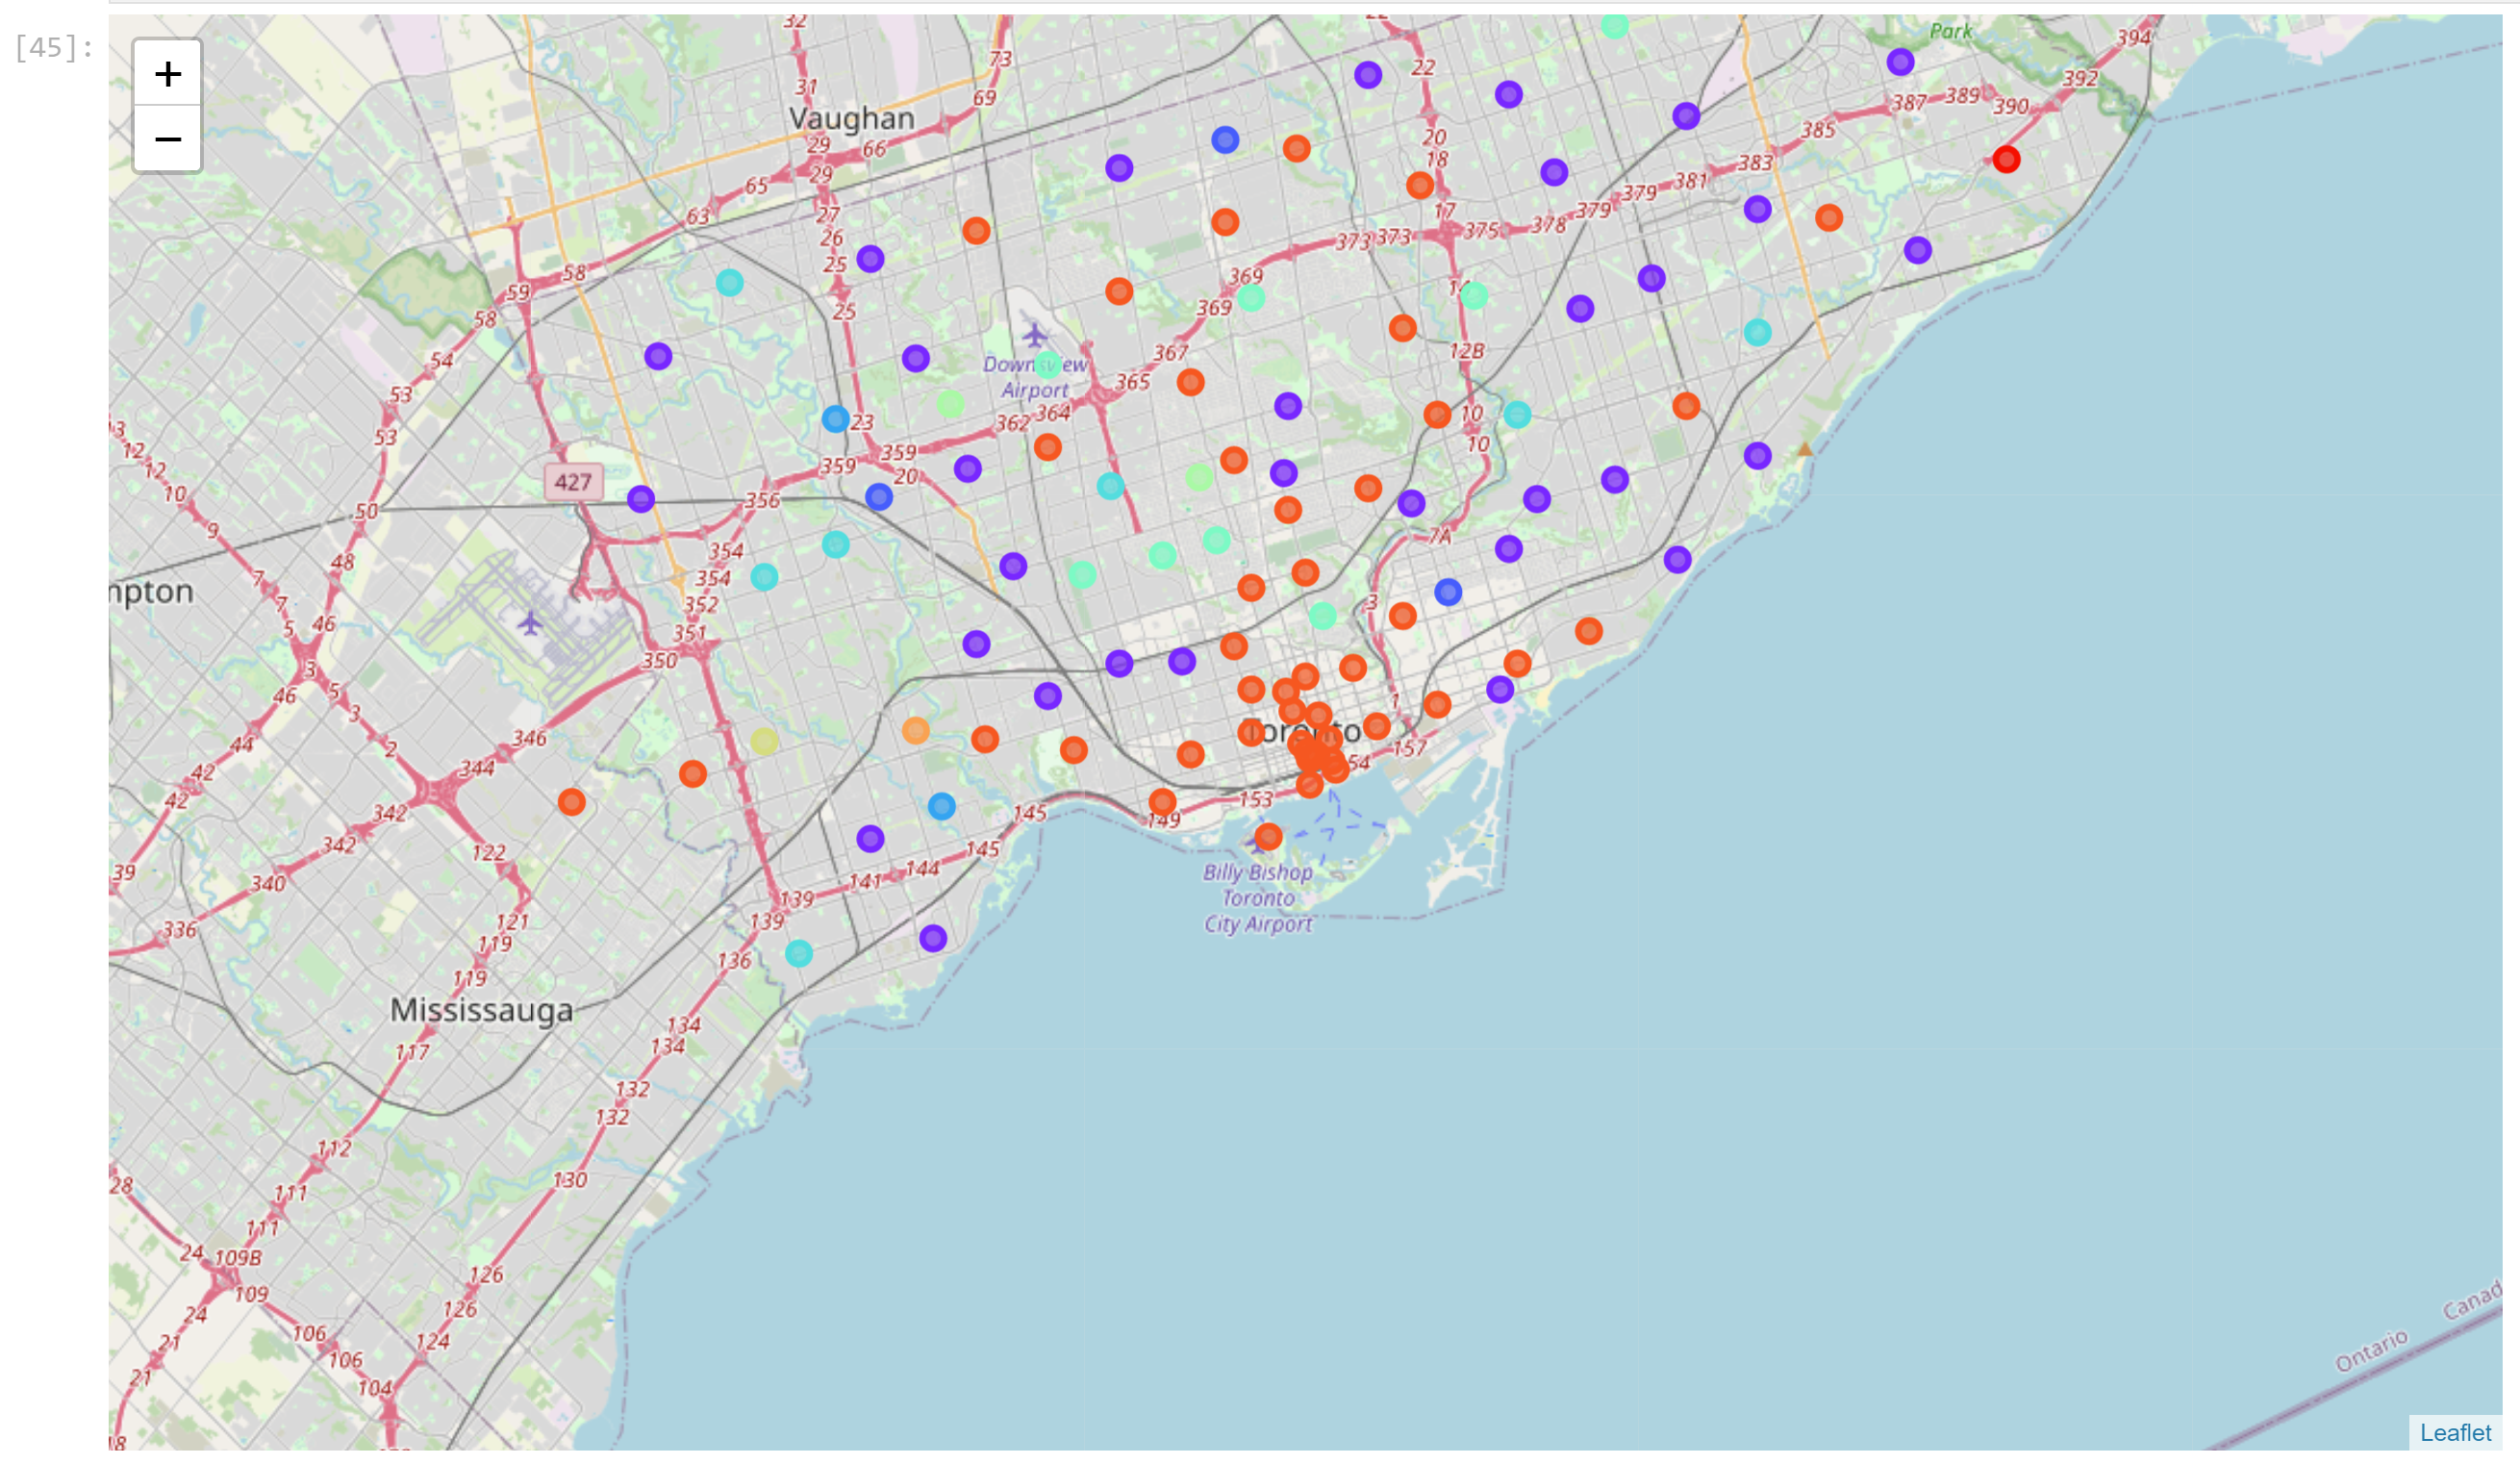

We can see that there is a large cluster centered around downtown, implying that the venues in downtown are more similar than the ones in the suburbs.